In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from libra_toolbox.tritium.model import (
    quantity_to_activity,
    activity_to_quantity,
)
from libra_toolbox.tritium.plotting import (
    ureg,
    plot_bars,
    plot_integrated_top_release,
    plot_integrated_wall_release,
    plot_irradiation,
    plot_sample_activity_top,
    plot_sample_activity_wall,
    plot_salt_inventory,
    plot_top_release,
    plot_wall_release,
)

ureg.mpl_formatter = "{:~P}"
# remove top and right axes by default
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# set axis below true by default
plt.rcParams["axes.axisbelow"] = True

from tritium_model import *

Processed data stored in ../../data/processed_data.json


/opt/conda/envs/libra-run-env/lib/python3.12/site-packages/libra_toolbox/tritium/lsc_measurements.py:140: UserWarning: Activity of 1L-IV_3-1-1 is negative after substracting background. Setting to zero.
  warnings.warn(
/opt/conda/envs/libra-run-env/lib/python3.12/site-packages/libra_toolbox/tritium/lsc_measurements.py:140: UserWarning: Activity of 1L-IV_3-1-2 is negative after substracting background. Setting to zero.
  warnings.warn(
/opt/conda/envs/libra-run-env/lib/python3.12/site-packages/libra_toolbox/tritium/lsc_measurements.py:140: UserWarning: Activity of 1L-IV_3-1-4 is negative after substracting background. Setting to zero.
  warnings.warn(
/opt/conda/envs/libra-run-env/lib/python3.12/site-packages/libra_toolbox/tritium/lsc_measurements.py:140: UserWarning: Activity of 1L-IV_3-3-1 is negative after substracting background. Setting to zero.
  warnings.warn(
/opt/conda/envs/libra-run-env/lib/python3.12/site-packages/libra_toolbox/tritium/lsc_measurements.py:140: UserWarning: A

Quantity of T consumed: 3.95×10¹² particle
Uncertainty on T consumed: 3.52×10¹¹ particle
Quantity of T consumed: 7.06×10³ Bq
Quantity of T produced: 5.87×10⁰ Bq
Quantity of T produced: 3.29×10⁹ particle
Measured TBR: 8.32e-04 particle / neutron
2.4552275990845733 dimensionless


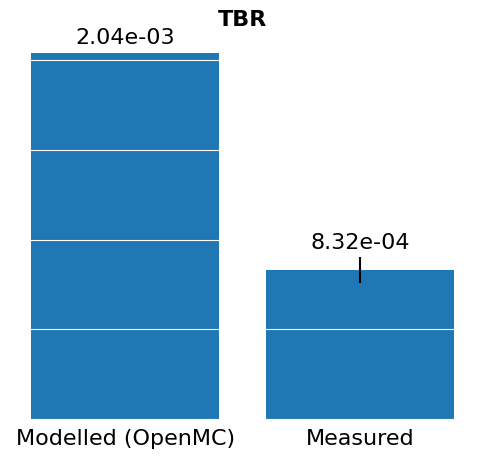

In [2]:
print(f"Quantity of T consumed: {T_consumed.to(ureg.particle):.2e~P}")
print(f"Uncertainty on T consumed: {(neutron_rate_relative_uncertainty * T_consumed).to(ureg.particle):.2e~P}")
print(f"Quantity of T consumed: {quantity_to_activity(T_consumed).to(ureg.Bq):.2e~P}")
print(f"Quantity of T produced: {T_produced:.2e~P}")
print(f"Quantity of T produced: {activity_to_quantity(T_produced).to(ureg.particle):.2e~P}")
print(f"Measured TBR: {measured_TBR:.2e}")
plt.figure(figsize=(6, 5))
bars = plt.bar(
    [0, 1],
    [calculated_TBR, measured_TBR],
    tick_label=["Modelled (OpenMC)", "Measured"],
    yerr=[0, neutron_rate_relative_uncertainty * measured_TBR],
)

plt.bar_label(bars, fontsize=16, fmt="%.2e", padding=3)
plt.title("TBR", weight="bold", fontsize=16)
plt.ylabel("")
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels
plt.gca().tick_params(axis="both", which="both", left=False, bottom=False, labelsize=16)
plt.gca().set_axisbelow(False)
plt.grid(axis="y", alpha=1, color="white", zorder=-10)
# plt.tight_layout()
print((calculated_TBR/measured_TBR).to(ureg.dimensionless))
plt.savefig("tbr_comparison.pdf", bbox_inches="tight")
plt.show()

In [3]:
baby_model.run(50 * ureg.day)


/home/codespace/.local/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


In [4]:
print(f"Transport:")
print(f"  mass transport coeff top: {baby_model.k_top:.2e~P}")
print(f"  mass transport coeff wall: {baby_model.k_wall:.2e~P}")

print("Source:")
print(f"  TBR: {baby_model.TBR:.2e~P}")
print(f"  neutron rate: {baby_model.neutron_rate:.2e~P}")
print(f"  neutron rate * TBR: {baby_model.neutron_rate * baby_model.TBR:.2e~P}")
# print(f"  k_top/k_wall: {baby_model.k_top/baby_model.k_wall:.2f~P}")

print("Geometry:")
print(f"  volume: {baby_model.volume.to(ureg.cm**3):.2f~P}")
print(f"  top area: {baby_model.A_top.to(ureg.cm**2):.2f~P}")
print(f"  wall area: {baby_model.A_wall.to(ureg.cm**2):.2f~P}")

Transport:
  mass transport coeff top: 8.90×10⁻⁸ m/s
  mass transport coeff wall: 1.51×10⁻⁹ m/s
Source:
  TBR: 2.39×10⁻³ particle/n
  neutron rate: 9.15×10⁷ n/s
  neutron rate * TBR: 2.19×10⁵ particle/s
Geometry:
  volume: 1000.00 cm³
  top area: 153.94 cm²
  wall area: 445.87 cm²


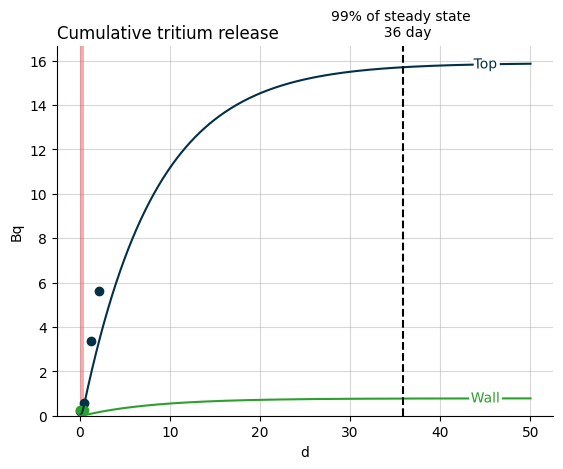

In [5]:
plt.figure()
(l,) = plot_integrated_top_release(baby_model, color="#023047", label="Top")
plot_integrated_wall_release(baby_model, color="tab:green", label="Wall")
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)
plt.grid(alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[45]*2)
plt.ylim(bottom=0 * ureg.Bq)

plt.scatter(
    replacement_times_top, IV_stream.get_cumulative_activity("total"), color="#023047"
)
plt.scatter(
    replacement_times_walls,
    OV_stream.get_cumulative_activity("total"),
    color="tab:green",
)

# add line where top is 99% of final
ydata = l.get_ydata()
xdata = l.get_xdata()
target_release_frac = 0.99
x_target = xdata[np.argmax(ydata > target_release_frac * ydata[-1])]

plt.axvline(x=x_target, color="k", linestyle="--")
plt.annotate(
    f"99% of steady state \n {x_target: .0f}",
    (x_target, target_release_frac * ydata[-1]),
    xytext=(0, 20),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="k",
)

plt.title("Cumulative tritium release", loc="left")
# plt.ylim(top=20)

plt.savefig("cumulative_release.pdf", bbox_inches="tight")

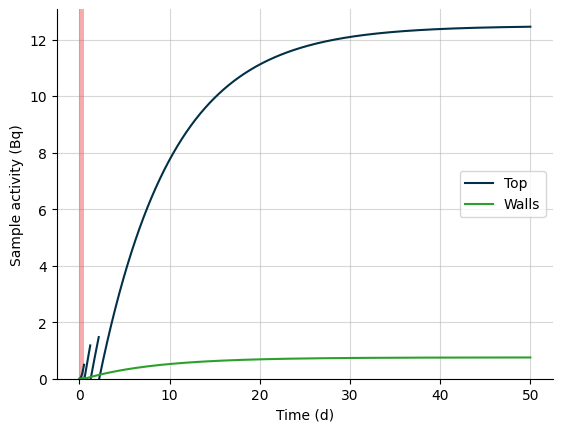

In [6]:
plot_sample_activity_top(baby_model, replacement_times=replacement_times_top, color="#023047", label="Top")
plot_sample_activity_wall(baby_model, replacement_times=replacement_times_walls, color="tab:green", label="Walls")
plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)
plt.ylim(bottom=0 * ureg.Bq)

plt.ylabel(f"Sample activity ({plt.gca().yaxis.get_units():~P})")
plt.xlabel(f"Time ({plt.gca().xaxis.get_units():~P})")
plt.legend()
plt.grid(alpha=0.5)

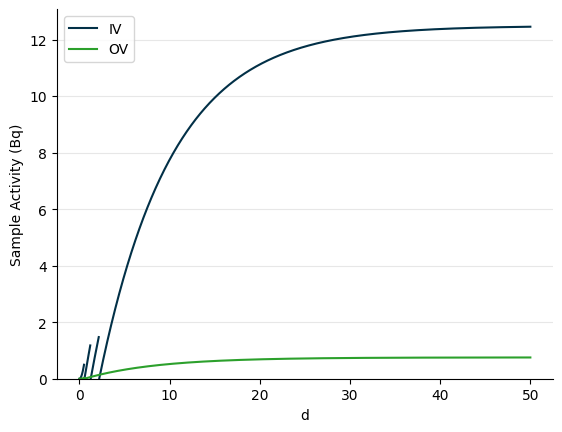

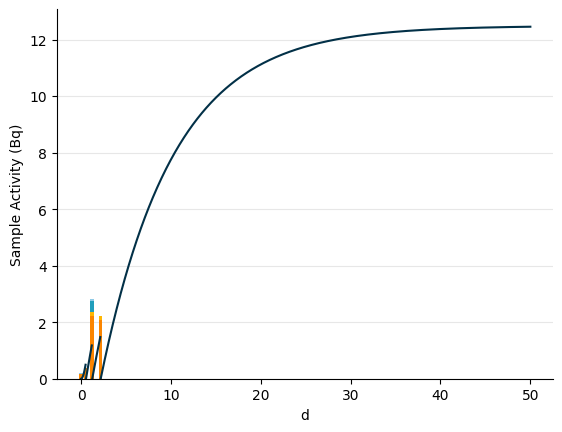

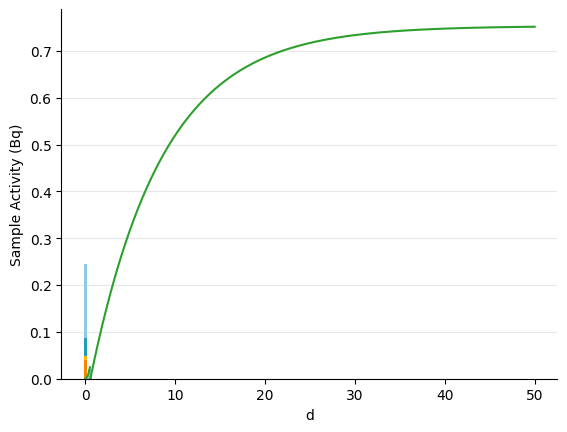

In [7]:
plt.figure()
plot_sample_activity_top(baby_model, replacement_times=replacement_times_top, color="#023047", label="IV")
plot_sample_activity_wall(baby_model, replacement_times=replacement_times_walls, color="tab:green", label="OV")
plt.grid(True, axis="y", alpha=0.3)
plt.ylim(bottom=0 * ureg.Bq)
plt.ylabel("Sample Activity (Bq)")
plt.legend()

plt.figure()
plot_bars(IV_stream, index=[time.to(ureg.day) for time in replacement_times_top])
plot_sample_activity_top(baby_model, replacement_times=replacement_times_top, color="#023047", label="Model")

plt.grid(True, axis="y", alpha=0.3)
plt.ylim(bottom=0 * ureg.Bq)
# plt.xlim(0, 5)
# plt.ylim(top=3)
plt.ylabel("Sample Activity (Bq)")

plt.figure()
plot_bars(OV_stream, index=[time.to(ureg.day) for time in replacement_times_walls])
plot_sample_activity_wall(baby_model, replacement_times=replacement_times_walls, color="tab:green", label="Model")

plt.grid(True, axis="y", alpha=0.3)
# plt.ylim(bottom=0 * ureg.Bq)
# plt.xlim(0, 3)
plt.ylabel("Sample Activity (Bq)")

plt.show()